In [2]:
import pandas as pd
import numpy as np
import math
import os 
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from Amplitude import Amplitude
from visualization import contour_generator
from style import set_style

In [60]:
def plot_normalized(ax,energy,tag=' ',line='-'):
    global T
    ax.set_prop_cycle(None)
    ax.plot(energy.t/T, energy.ke/(energy.total[0]), label='ke '+tag, linestyle=line)
    ax.plot(energy.t/T, energy.gpe/(energy.total[0]), label='gpe '+tag, linestyle=line)
    ax.plot(energy.t/T, energy.total/energy.total[0], label='total '+tag, linestyle=line)
    ax.set_ylabel("E/E0")

def plot(ax,energy,tag=' ',line='-'):
    ax.set_prop_cycle(None)
    ax.plot(energy.t, energy.ke, label='ke '+tag, linestyle=line)
    ax.plot(energy.t, energy.gpe, label='gpe '+tag, linestyle=line)
    ax.plot(energy.t, energy.total/2, label='total/2 '+tag, linestyle=line)
    ax.set_ylabel("E")
    
from scipy.signal import argrelextrema
def fit(ax,energy,localmax=1):
    global T
    t = np.array(energy.t); total = np.array(energy.total)/2
    if localmax:
        localmax_index = argrelextrema(total, np.greater)[0]
        localmax_time = t[localmax_index]
        localmax = total[localmax_index]
        ax.plot(localmax_time,localmax,'.')
        a, b = np.polyfit(localmax_time, np.log(localmax), 1)  
    else:
        a, b = np.polyfit(t, np.log(total), 1)
    ax.plot(t, np.exp(b)*np.exp(a*t), linestyle='-.', label = 'a = %g' %(a/T))
    return (a/T)   

def read(name, delimiter = ' ', skip = None):
    energy,exists = readin(path+name, table_delimiter = delimiter, 
                       table_headers = ['t', 'ke', 'gpe'], skipn = skip)
    if exists:
        total = energy.ke + energy.gpe 
    energy.insert(len(energy.columns), "total", total, True)
    energy = energy.sort_values(by=['t'])
    return energy

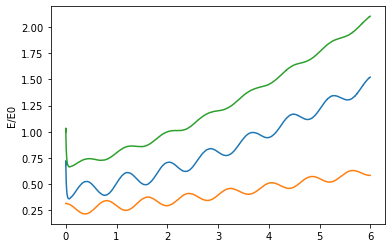

In [4]:
fig = plt.figure(); ax = fig.gca()
working_dir = '/home/jiarong/research/projects/windwave/'
path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11/'
energy1 = read('budgetWaterwind.dat', skip = 10)
T = 0.5
plot_normalized(ax,energy1,'base')

In [ ]:
###### Linear case
# Four waves in one box
fig = plt.figure(); ax = fig.gca()
path = '/home/jiarong/research/projects/windwave/' + \
        'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11/'
energy1 = read('budgetWaterwind.dat', skip = 10)
plot(ax,energy1,'ak=0.2')
# plt.xlim([0,1]); plt.ylim([0,2])

0.323916183676405
0.04443742336128841
11.555894
15.787581
19.577854
24.324009


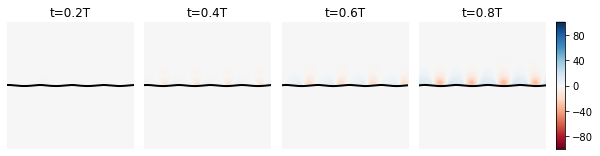

In [5]:
'''
    Plot the pressure and shear distribution along the wave
'''
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

Ustar = 0.6; sigma = 0.074/1000.; g = 9.8; k = 2*np.pi*16
common_path = '/home/jiarong/research/projects/windwave/linlog/' + \
                'wavewind_real_linlog_waves4L00.25Ustar0.6ak0.1BoReLEVEL13REGION0.2'
common_path = '/home/jiarong/research/projects/windwave/linlog/' + \
                'wavewind_real_linlog_waves4L00.25Ustar0.6ak0.1BoReLEVEL11REGION0.2'
c = (g/k+sigma*k)**0.5; print(c)
tau0 = 1000/850*(Ustar*c)**2  ;  print(tau0)
L0 = 0.25
snapshot = [2,4,6,8]
for i,ax in zip(snapshot,grid):
    pfile = common_path + '/pressure/f_matrix%g.dat' %(i/10)
    data = np.fromfile(pfile, dtype=np.float32)
    data = data.reshape((513,513))
    data = data[1:,1:]
    f = data
    pfile = common_path + '/pressure/p_air_matrix%g.dat' %(i/10)
    pressure = np.fromfile(pfile, dtype=np.float32)
    pressure = pressure.reshape((513,513))
    pressure = pressure[1:,1:]
    p_air = pressure
    aver = p_air.mean()
    print(aver)
#    p_air_filtered = medfilt(p_air, 11)
    # Plot the interface
    etafile = common_path + '/field/eta%g' %(i/10)
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
        ampl = Amplitude(eta[['x', 'eta', 'f']], 512, L0)    
    image = np.rot90((p_air-aver*2)*(1-f)/tau0)
    absmax = 100
    pcontour = ax.imshow(image, extent=(-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu', 
                         vmax=absmax, vmin=-absmax)
    ax.plot(ampl._eta_data.x, ampl._eta_data.eta, color='k', linewidth=2)
    ax.set_axis_off()
    ax.set_title('t=%gT' %(i/10))
ax.cax.colorbar(pcontour)
ax.cax.toggle_label(True)
# fig.tight_layout(h_pad=1)

In [ ]:
'''Find shear and wave growth partition'''


0.037791359999999996
13.268595


KeyError: "['p_p4' 'tau_x' 'tau_x_p2'] not in index"

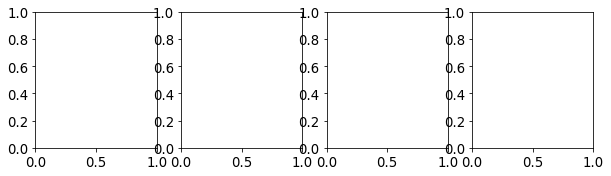

In [6]:
# rc('text', usetex=True)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['xtick.labelsize'] = 'smaller'
plt.rcParams['ytick.labelsize'] = 'smaller'
plt.rcParams['legend.fontsize'] = 'small'

from scipy.signal import medfilt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(10,2.5))
grid = [ax1, ax2, ax3, ax4]

common_path = '/home/jiarong/research/projects/windwave/linlog/' + \
                'wavewind_real_linlog_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2'
c = 0.324; ustar = 0.6*c; tau0 = ustar**2
print(tau0)

for i,ax in zip([2,3,6,8],grid):
    t = 0.1*i
    # Compute the p mean
    pfile = common_path + '/pressure/p_air_matrix%g.dat' %(i/10)
    pressure = np.fromfile(pfile, dtype=np.float32)
    pressure = pressure.reshape((513,513))
    pressure = pressure[1:,1:]
    p_air = pressure
    aver = p_air.mean()
    print(aver)
    # Plot the interface
    etafile = common_path + '/field/eta%g' %t
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
        ampl = Amplitude(eta[['x', 'eta', 'f', 'p_p2', 'p_p4', 'tau_x', 'tau_x_p2']])
    ax.plot(ampl._eta_data.x, ampl._eta_data.eta*10000, color='k', linewidth=2, label=r'$100\eta / \lambda$')    
    tau_filter = medfilt(ampl._eta_data.tau_x_p2,101)
#    ax.plot(ampl._eta_data.x, tau_filter/tau0, label=r'$\tau_{visc}/ \tau$')
    p_filter = medfilt(ampl._eta_data.p_p4, 101)
    p_filter = p_filter-np.average(p_filter)
#    ax.plot(ampl._eta_data.x, (p_filter-aver)/tau0, label=r'$\Delta p/ \tau$')
    # Compute slope
    poly = np.polyfit(ampl._eta_data.x, ampl._eta_data.eta, 5)
    poly_deriv = np.polyder(poly)
    slope = np.polyval(poly_deriv, ampl._eta_data.x)
    ax.plot(ampl._eta_data.x, slope, label = r'$\partial{\eta}/\partial{x}$')
    # Plot value times slope ...
    ax.plot(ampl._eta_data.x, (p_filter)/tau0, label=r'$(p_s^\prime/\tau_0)$')
    # ax.plot(ampl._eta_data.x, slope*(p_filter-aver)/tau0, label=r'$(p_s^\prime/\tau_0)\partial{\eta}/\partial{x}$')
    ax.plot(ampl._eta_data.x, tau_filter/(1+slope**2)/tau0, label=r'$\frac{(\tau_{visc}/\tau_0)}{\sqrt{1+(\partial{\eta}/\partial{x})^2}}$')
#     ax.set_title('t=%gT' %(i/32))
ax4.legend(fontsize=10,loc='upper right')

# ax.xaxis.set_ticks_position('top')
for ax in grid:
    ax.get_xaxis().set_ticks([])
    ax.set_ylim([-10,10])
ax1.yaxis.set_ticks([]); ax2.yaxis.set_ticks([]); ax3.yaxis.set_ticks([]);
ax4.yaxis.set_ticks_position('right')
# ax.tick_params(colors='black')
# xticks = ax1.xaxis.get_major_ticks()
# xticks.set_visible(False)
# yticks = ax1.yaxis.get_major_ticks()
# yticks.set_visible(False)

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=None)

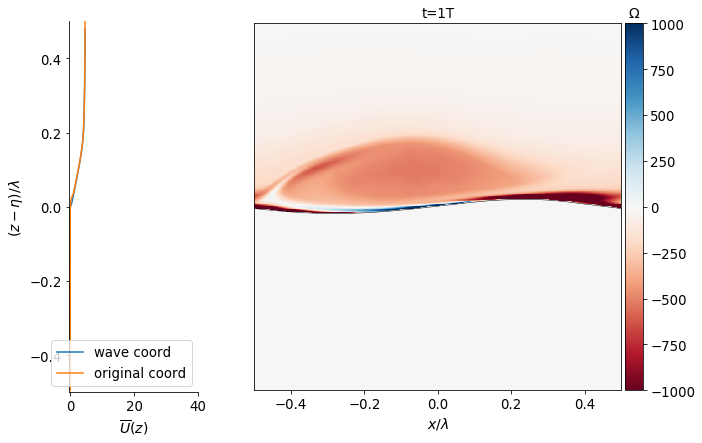

In [8]:
# Air profile evolution 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
def air_profile(t,ax1,ax2):
    global common_path,L0
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(t)
    # Draw contour
    pcontour,pvof = draw_field(omega_air, t, ax2, absmax = 1000)
#     pcontour,pvof = draw_field(u_air, t, ax2, absmax=5)
    # Colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.set_title(r'$\Omega$',fontsize=14)
    plt.colorbar(pcontour, cax=cax)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_xlabel(r'$x/\lambda$',fontsize=14)
    # Average profile (wave coordinate!)
    u_air_1D_nointerp = np.average(u_air, axis=0)
    u_air_interp = np.zeros(u_air.shape)
    ampl = interface(t)
    zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
    zgrid = np.linspace(zmin, zmax, 512)
    from scipy.interpolate import interp1d
    for i in range(u_air.shape[0]):
        z = np.linspace(-L0/2,L0/2,512) - ampl.eta_interp[i]
        f = interp1d(z, u_air[i,:])
        f = interp1d(z, u_air[i,:], kind='cubic')
        ugrid = f(zgrid)
        u_air_interp[i] = ugrid
    u_air_1D = np.average(u_air_interp, axis=0)
    # Average profile method 2
#     u,f,omega = fields_original(t)
#     for i in range(u_air.shape[0]):
#         z = np.linspace(-L0/2,L0/2,512) - ampl.eta_interp[i]
#         fu = interp1d(z, u[i,:])
#         ff = interp1d(z, f[i,:])
#         ugrid = fu(zgrid)*(1-ff(zgrid))
#         u_air_interp[i] = ugrid
#     u_air_1D = np.average(u_air_interp, axis=0)    
    # Plot
    ax1.plot(u_air_1D, zgrid/L0, label = 'wave coord')
    ax1.plot(u_air_1D_nointerp, z/L0, label = 'original coord')    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_ylabel(r'$(z-\eta)/\lambda$',fontsize=14); ax1.set_xlabel(r'$\overline{U}(z)$',fontsize=14)
    ax1.set_ylim([-0.5,0.5])
    ax1.set_xlim([-0.5,40])
    ax1.legend(loc='lower right')
    return u_air, u_air_interp

# Example
working_dir = '/home/jiarong/research/projects/windwave/linlog/'
common_path = working_dir + 'wavewind_real_linlog_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2'
L0 = 0.0625
fig = plt.figure(figsize=(9, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
plt.tight_layout()
u_air, u_air_interp = air_profile(1,ax1,ax2)

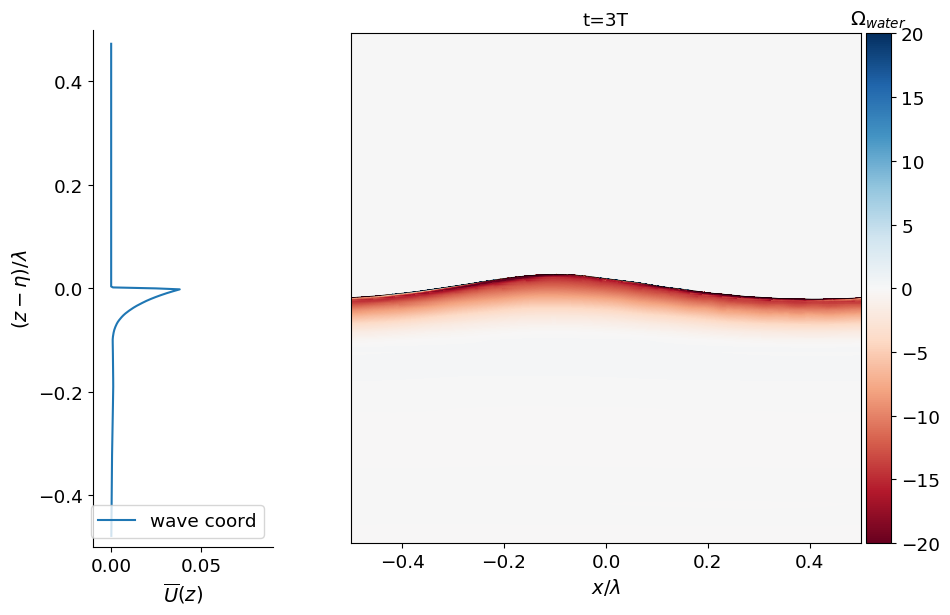

In [24]:
# Water profile evolution: current evolution 
def water_profile(t,ax1,ax2):
    global common_path,L0
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(t)
    pcontour,pvof = draw_field(omega_water, t, ax2, absmax = 20)
#     pcontour,pvof = draw_field(u_water, t, ax2, absmax = 0.2)
    # Colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     cax.set_title(r'$u_{water}$',fontsize=14)
    cax.set_title(r'$\Omega_{water}$',fontsize=14)
    plt.colorbar(pcontour, cax=cax)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_xlabel(r'$x/\lambda$',fontsize=14)
    # Average profile (wave coordinate!)
    u_water_1D_nointerp = np.average(u_water, axis=0)
    u_water_interp = np.zeros(u_water.shape)
    ampl = interface(t)
    zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
    zgrid = np.linspace(zmin, zmax, 512)
    from scipy.interpolate import interp1d
    for i in range(u_water.shape[0]):
        z = np.linspace(-L0/2,L0/2,512) - ampl.eta_interp[i]
        f = interp1d(z, u_water[i,:])
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp, axis=0)
    ax1.plot(u_water_1D, zgrid/L0, label = 'wave coord')
#     ax1.plot(u_water_1D_nointerp, z/L0, label = 'original coord')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_ylabel(r'$(z-\eta)/\lambda$',fontsize=14); ax1.set_xlabel(r'$\overline{U}(z)$',fontsize=14)
    ax1.set_ylim([-0.5,0.5])
    ax1.set_xlim([-0.01,0.09])
    ax1.legend(loc='lower right')
    return u_water, u_water_interp
    
# Example
working_dir = '/home/jiarong/research/projects/windwave/'
common_path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11'
working_dir = '/home/jiarong/research/projects/windwave/linlog/'
common_path = working_dir + 'wavewind_real_linlog_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2'
L0 = 0.0625
fig = plt.figure(figsize=(9, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
plt.tight_layout()
u_water, u_water_interp = water_profile(3,ax1,ax2)

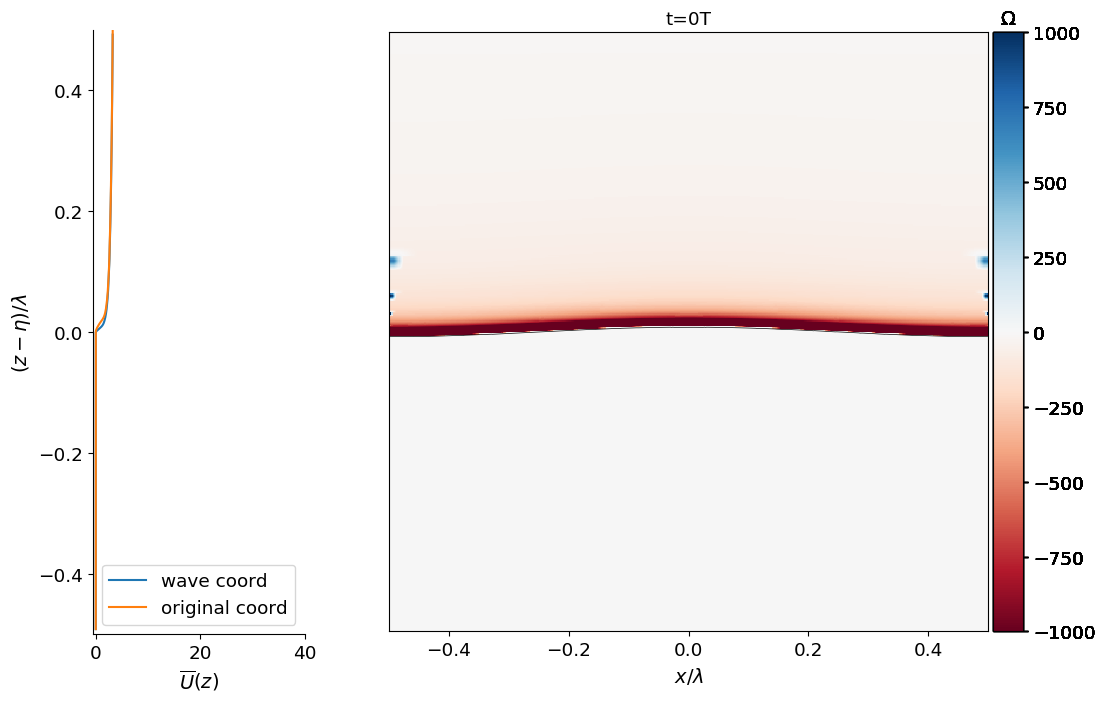

In [27]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 100

# Single animation generation function
def plot_animation(frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate   
    global common_path,N,L0,kp,deltat
    fig = plt.figure(figsize=(12,8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    air_profile(0,ax1,ax2)

    # animation function.  This is called sequentially
    def animate(i):
        global common_path
        ax1.clear(); ax2.clear()
#         ax1.axhline(0.05,ls='--',color='C7')
        t = i*deltat
        air_profile(t,ax1,ax2)
        return fig

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = False)  
    return anim

working_dir = '/home/jiarong/research/projects/windwave/linlog/'
common_path = working_dir + 'wavewind_real_linlog_coarser_waves1L00.055Ustar0.6ak0.05BoReLEVEL11REGION0.05_comparetolinear'
L0 = 0.055; deltat = 0.1
# working_dir = '/home/jiarong/research/projects/windwave/linear/'
# common_path = working_dir + 'linear_adaptive_limited_m5B0Ustar0.6ak0.1Bo10Re10000.LEVEL11REGION0.1'
# L0 = 1; deltat = 0.03125
anim = plot_animation(frame_number = 15, interval_time = 400) # Specify frame number
HTML(anim.to_html5_video())

In [157]:
0.32**2/2/9.8*(1-0.02/0.32)**2

0.004591836734693878

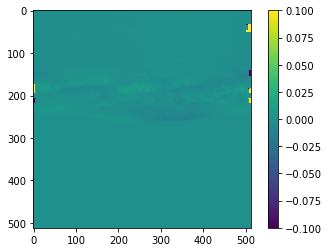

In [65]:
t = 2
working_dir = '/home/jiarong/research/projects/windwave/linlog/'
common_path = working_dir + 'wavewind_real_linlog_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2'
u_air, u_water, omega_air, omega_water = fields(t)
u_air1 = u_air.copy()
common_path = working_dir + 'wavewind_real_linlog_ve_region_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2'
u_air, u_water, omega_air, omega_water = fields(t)
u_air2 = u_air.copy()
plt.imshow(np.rot90(u_air2-u_air1), vmax = 0.1, vmin = -0.1)
plt.colorbar()

(0, 10)

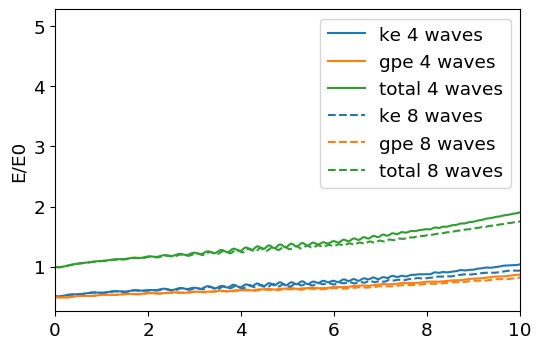

In [45]:
fig = plt.figure(); ax = fig.gca()
T = 0.196
# path = '/home/jiarong/research/projects/windwave/linlog/' + \
#         'wavewind_real_linlog_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2/'
# energy1 = read('budgetWaterwind.dat', skip = 10)
# plot_normalized(ax,energy1,'region = 0.2')
path = '/home/jiarong/research/projects/windwave/linlog/' + \
        'wavewind_real_linlog_ve_coarser_waves4L00.25Ustar0.6ak0.1BoReLEVEL11REGION0.05/'
energy2 = read('budgetWaterwind.dat', skip = 10)
plot_normalized(ax,energy2,'4 waves')
path = '/home/jiarong/research/projects/windwave/linlog/' + \
        'wavewind_real_linlog_ve_coarser_waves8L00.5Ustar0.6ak0.1BoReLEVEL12REGION0.05/'
energy2 = read('budgetWaterwind.dat', skip = 10)
plot_normalized(ax,energy2,'8 waves', '--')
plt.legend()
plt.xlim([0,10])
# plt.xlim([0,2]); plt.ylim([0,1])

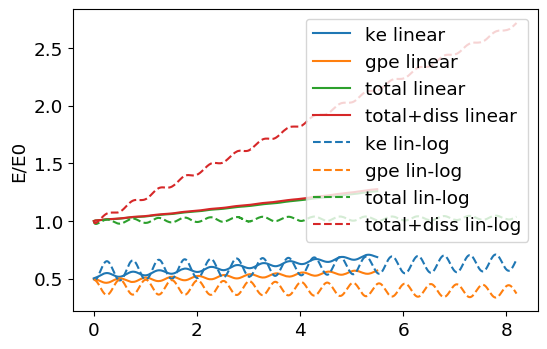

In [91]:
fig = plt.figure(); ax = fig.gca()
# path = '/home/jiarong/research/projects/windwave/linlog/' + \
#         'wavewind_real_linlog_waves1L00.0625Ustar0.6ak0.1BoReLEVEL11REGION0.2/'
# energy1 = read('budgetWaterwind.dat', skip = 10)
# plot_normalized(ax,energy1,'region = 0.2')
path = '/home/jiarong/research/projects/windwave/' + \
        'linear/linear_adaptive_limited_m5B0Ustar0.4ak0.05Bo10Re20000.LEVEL11REGION0.05/'
energy1 = read('budgetWaterwind.dat', skip = 10)
# Already normalized by an inaccurate number k/(g*k)**0.5
T = 2.5/2.62897
decay1 = 2*1/20000*0.05**2*(2*np.pi/1)*0.41**3 ; decay = decay1
plot_normalized(ax,energy1,'linear')
path = '/home/jiarong/research/projects/windwave/' + \
        'linlog/wavewind_real_linlog_coarser_waves1L00.03Ustar0.4ak0.05BoReLEVEL11REGION0.05_comparetolinear/'
energy2 = read('budgetWaterwind.dat', skip = 10)
T = 0.12
# Decay as 2nu*k^3(ac)^2
decay2 = 2*8.9e-4*0.05**2*(2*np.pi/0.03)*0.25**3 ; decay = decay2
plot_normalized(ax,energy2,'lin-log','--')
# path = '/home/jiarong/research/projects/windwave/' + \
#         'linlog/wavewind_real_linlog_coarser_waves4L00.12Ustar0.4ak0.05BoReLEVEL11REGION0.05_comparetolinear/'
# energy2 = read('budgetWaterwind.dat', skip = 10)
# T = 0.12
# plot_normalized(ax,energy2,'lin-log 4 waves','-.')
# plt.xlim([0,5])
# path = '/home/jiarong/research/projects/windwave/' + \
#         'linear/linear_adaptive_limited_m5B0Ustar0.6ak0.05Bo10Re10000.LEVEL11REGION0.1/'
# energy3 = read('budgetWaterwind.dat', skip = 10)
# T = 0.988
# plot_normalized(ax,energy3,'ak=0.05, region=0.1',':')
plt.legend()

In [87]:
decay2/decay1

134.5139120635704

In [75]:
def plot_normalized(ax,energy,tag=' ',line='-'):
    global T,decay
    ax.set_prop_cycle(None)
    ax.plot(energy.t/T, energy.ke/(energy.total[0]), label='ke '+tag, linestyle=line)
    ax.plot(energy.t/T, energy.gpe/(energy.total[0]), label='gpe '+tag, linestyle=line)
    ax.plot(energy.t/T, energy.total/energy.total[0], label='total '+tag, linestyle=line)
    ax.plot(energy.t/T, (energy.total+decay*energy.t)/energy.total[0], label='total+diss '+tag, linestyle=line)
    ax.set_ylabel("E/E0")
def plot(ax,energy,tag=' ',line='-'):
    ax.set_prop_cycle(None)
    ax.plot(energy.t, energy.ke, label='ke '+tag, linestyle=line)
    ax.plot(energy.t, energy.gpe, label='gpe '+tag, linestyle=line)
    ax.plot(energy.t, energy.total, label='total '+tag, linestyle=line)
    ax.plot(energy.t, (energy.total+decay*energy.t), label='total+diss '+tag, linestyle=line)
    ax.set_ylabel("E")

In [ ]:
# Set the style
set_style()

In [35]:
# Phase average
ampl.x_interp.size

localmax_index1 = argrelextrema(ampl.eta_interp, np.greater)[0]
localmax_index2 = argrelextrema(ampl.eta_interp[localmax_index1], np.greater)[0]
plt.plot(ampl.x_interp,ampl.eta_interp)
localmax_x1 = ampl.x_interp[localmax_index1]
localmax_eta1 = ampl.eta_interp[localmax_index1]
plt.plot(localmax_x1, localmax_eta1, '.')
localmax_x2 = localmax_x1[localmax_index2]
localmax_eta2 = localmax_eta1[localmax_index2]
plt.plot(localmax_x2, localmax_eta2, '.')
# plt.plot(ampl.x_interp,ampl.eta_interp)
# plt.plot(ampl._eta_data.x, ampl._eta_data.eta)
# plt.ylim([-0.5,0.5])

NameError: name 'ampl' is not defined

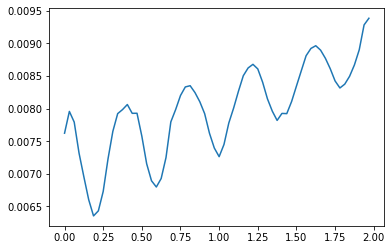

In [10]:
from scipy.signal import argrelextrema
etamax = np.zeros(64); t = np.zeros(64)
working_dir = '/home/jiarong/research/projects/windwave/'
common_path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11'
L0 = 1
for i in range (0, 64):
    t[i] = i/32.
    ampl = interface(t[i])
    etamax[i] = ampl.eta_interp.max()
plt.plot(t, etamax)

In [ ]:
# Wind evolution